# import

In [39]:
import spikeinterface.full as si
import os
from open_ephys.analysis import Session
import re
import numpy as np
import pandas as pd
import glob 
from scipy.signal import butter, sosfilt, sosfilt_zi
from tqdm import tqdm
import matplotlib.pyplot as plt
    
# Define the bandpass filter
def create_bandpass_filter(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos
    
def list_all_datapaths(data_path):
    data_paths = []
    for file in os.listdir(data_path):
        if 'EJT' in file[0:5] or 'revision' in data_path:
            for file_ in os.listdir(data_path+file):
                if 'record' in file_:
                    data_paths += [data_path+file+'\\'+file_]
            
    return data_paths

def walk_through_files_countinous_data(recording_path_1):
    continuous_file_path = None

    for root, dirs, files in os.walk(recording_path_1):
        if 'continuous.dat' in files:
            continuous_file_path = os.path.join(root, 'continuous.dat')
            break

    if continuous_file_path:
        print(f"Found 'continuous.dat' at: {continuous_file_path}")
        return continuous_file_path
    else:
        print("'continuous.dat' not found in the specified path.")
        
def find_processor_tuples(processor_path):
    count = 0
    for processor in os.listdir(processor_path):
        if count == 0:
            main1 = int(re.findall(r'\d+', processor)[0])
            main1_2 = processor.split('.')[-1]
        elif count == 1:
            main2 = int(re.findall(r'\d+', processor)[0])
            main2_2 = processor.split('.')[-1]
        elif count == 2:
            main3 = int(re.findall(r'\d+', processor)[0])
            main3_2 = processor.split('.')[-1]
        count +=1 

    main_processor_tuple=(main1, main1_2)

    aux_processor_tuples=((main2,main2_2),(main3,main3_2))
    return main_processor_tuple,aux_processor_tuples

def process_probe_data_bool(organised_ephys_path,aux_processor_tuples):
    process = False
    if not 'global-timstamps_event-df.pkl' in os.listdir(organised_ephys_path):
        if not 'main_continuous_global_ts_probeA.npy' in os.listdir(organised_ephys_path):
            if not 'LFP' in aux_processor_tuples[0][-1]:
                if not 'main_continuous_global_ts_probeA_LFP.npy' in os.listdir(organised_ephys_path):
                    process = True
            else:
                if not 'main_continuous_global_ts_probeB.npy' in os.listdir(organised_ephys_path):
                    process = True
    return process

## new version for new open ephys tools 
def align_open_ephys_processors(main_processor_tuple, aux_processor_tuples,raw_data_directory, sync_channel=1):

    session_data = Session(str(raw_data_directory))
    if len(session_data.recordnodes) != 1:
        raise ValueError("should be exactly one record node.")
    if len(session_data.recordnodes[0].recordings) != 1:
        raise ValueError("Should be exactly one recording.")
    for rn, recordnode in enumerate(session_data.recordnodes):
        for r, recording in enumerate(recordnode.recordings):
            # Sync
            recording.add_sync_line(
                sync_channel,
                main_processor_tuple[0],
                main_processor_tuple[1],
                main=True,
            )
            for aux_processor in aux_processor_tuples:
                recording.add_sync_line(
                    sync_channel,
                    aux_processor[0],
                    aux_processor[1],
                    main=False,
                )
            print('this should be zero:')
            print(rn)
        
    return recording

def check_if_probe_is_flipped(A_probes):

    # Check if 'CP' appears before 'ccb or ccg' in the list of region acronyms, it shouldnt if the probe is the right way up
    if 'CP' in A_probes['Region acronym'].values and 'ccb' in A_probes['Region acronym'].values:
        if list(A_probes['Region acronym'].values).index('CP') < list(A_probes['Region acronym'].values).index('ccb'):
            print('cp appears first ')
            flipped = True
        else:
            print('cp appears second - good')
            flipped = False
    elif 'CP' in A_probes['Region acronym'].values and 'ccg' in A_probes['Region acronym'].values:
        if list(A_probes['Region acronym'].values).index('CP') < list(A_probes['Region acronym'].values).index('ccg'):
            print('cp appears first ')
            flipped = True
        else:
            print('cp appears second - good')
            flipped = False
    else:
        print('error')
    return flipped

def find_propotion_in_striatum(implant_df):
    try:
        callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccb')))
    except:
        callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccg')))

    if check_if_probe_is_flipped(implant_df):
        str_prop = callosum_middle_index/len(implant_df)
    else:
        str_prop = 1- callosum_middle_index/len(implant_df)
    return str_prop


def process_probe_channels(ProbeA_data,channels,channel_regions,current_mouse,output_path,var_string):
    # pull out the data for each channel, bandpass to prevent aliasing then downsample
         
    # Parameters
    lowcut = 20.0  # Lower cutoff frequency in Hz
    highcut = 1250.0  # Upper cutoff frequency in Hz
    fs = 30000.0  # Original sampling rate in Hz
    downsample_factor = 12  # Factor by which to downsample
    chunk_size = 2000  # Number of samples per chunk
    # Create the bandpass filter
    sos = create_bandpass_filter(lowcut, highcut, fs)
    # Initialize the filter state
    zi = sosfilt_zi(sos)

    # Process each channel
    for ind_,chosen_channel in enumerate(channels):
        data_channel = []
        for i in tqdm(range(0, len(ProbeA_data), chunk_size)):
            # Extract the current chunk for the chosen channel
            chunk = np.array([ProbeA_data[j][chosen_channel] for j in range(i, min(i + chunk_size, len(ProbeA_data)))])

            # Apply the bandpass filter to the chunk
            if i == 0:
                # For the first chunk, use the initial filter state
                bp_chunk, zi = sosfilt(sos, chunk, zi=zi * chunk[0])
            else:
                # For subsequent chunks, use the updated filter state
                bp_chunk, zi = sosfilt(sos, chunk, zi=zi)

            # Append the filtered chunk to the channel data
            data_channel.extend(bp_chunk)

        # Downsample the filtered data
        data_downsampled = data_channel[::downsample_factor]
        
        # clean up for memory
        del data_channel
        
        mouse_out_path = os.path.join(output_path,var_string) + current_mouse
        if not os.path.exists(mouse_out_path):
            os.makedirs(mouse_out_path)
            
        save_path = mouse_out_path + '//channel-' + str(chosen_channel) + '_REGION-' + channel_regions[ind_] + "_LFP_data.npy"
        np.save(save_path,data_downsampled)
        print('data saved for channel ' + str(chosen_channel))



def gather_paths_for_old_data(current_mouse,path):
    ### find OE processor path and OE_raw_path
    OE_processor_path_base = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\\"
    if current_mouse.split('_')[1] == 2:
        mouse_folder = 'EJT' + current_mouse.split('_')[0] + '_' + 'implant' + current_mouse.split('_')[1]
    else:
        mouse_folder = 'EJT' + current_mouse.split('_')[0] 
    for folder in os.listdir(OE_processor_path_base):
        if mouse_folder == folder:
            print(mouse_folder)
            OE_processor_path = OE_processor_path_base + folder + '\\'

    # next get the date 
    recording_date = path.split('\\')[-1].split('_')[-1]
    reformatted_date = ''.join(recording_date.split('-')[0:-1]) + recording_date.split('-')[-1][-2::]
    
    recording_path_1 = None
    for recording_date in os.listdir(OE_processor_path):
        if reformatted_date == recording_date:
            print(reformatted_date)
            recording_path_1 = os.path.join(OE_processor_path,recording_date) + '\\'
            
    # set some OE paths I need 
    continuous_file_path = walk_through_files_countinous_data(recording_path_1)
    processor_path = '\\'.join(continuous_file_path.split('\\')[0:-2])+ '\\'
    OE_raw_path = os.path.join(recording_path_1,os.listdir(recording_path_1)[0]) + '\\'
    return OE_raw_path,processor_path

def find_folder_path(parent_folder, target_folder):
    for root, dirs, files in os.walk(parent_folder):
        if target_folder in dirs:
            return os.path.join(root, target_folder)
        # If the target folder is not found
    return (print('not found'))


def gather_paths_for_new_data(mir):

    ## gather all raw ephys paths
    path_ = r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\"
    base_recording_paths = []
    for q in os.listdir(path_):
        if not 'other_sessions' in q:
            if not 'sp5_recordings' in q:
                folder = os.path.join(path_,q)
                for q in os.listdir(folder):
                    base_recording_paths+=[os.path.join(folder,q)]
                

    # gather the corespoding organised paths for each raw dat file 
    organised_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
    full_organised_paths = []
    mirs = []
    for i in range(len(base_recording_paths)):
        mouse_id = base_recording_paths[i].split('\\')[-1].split('_')[0]
        date_ = base_recording_paths[i].split('\\')[-1].split('_')[1]
        #reverse the date
        date_ = '-'.join(date_.split('-')[::-1])
        
        organised_path_animal = os.path.join(organised_path,mouse_id+'_implant1')

        for recording in os.listdir(organised_path_animal):
            if date_ in recording:
                full_organised_paths += [os.path.join(organised_path_animal,recording)]
                mirs += [mouse_id + '_1_' + recording.split('_')[0].split('g')[-1]]
                break


    for index in range(len(base_recording_paths)):
        
        mouse_id = base_recording_paths[index].split('\\')[-1].split('_')[0]
        date_ = base_recording_paths[index].split('\\')[-1].split('_')[1]
        #reverse the date
        date_ = '-'.join(date_.split('-')[::-1])
        
        
        probeB = False
        if mirs[index] == mir:
            print(mir)
            print(index)
            
            # set important paths
            raw_data_directory = base_recording_paths[index]
            print(raw_data_directory)
            OE_processor_path = find_folder_path(raw_data_directory, "continuous") 
            Behav_data_path = full_organised_paths[index]+ r'//behav_sync/2_task/Preprocessed//'

            Processed_Ephys_data_path_PROBEA = full_organised_paths[index]+ r'/ephys//' + r'probeA/kilosort4_output/sorter_output//'
            if 'probeB' in os.listdir(full_organised_paths[index]+ r'/ephys//'):
                print('Probe B found')
                Processed_Ephys_data_path_PROBEB = full_organised_paths[index]+ r'/ephys//' + r'probeB/kilosort4_output/sorter_output//'
                probeB = True
            
            organised_ephys_path = full_organised_paths[index]+ r'/ephys//'
            
            for vid_file in os.listdir(full_organised_paths[index] + r'\video\videos\\'):
                if 'BACK' in vid_file:
                    if 'avi' in vid_file:
                        back_video_path = os.path.join(full_organised_paths[index] + r'\video\videos\\',vid_file)

                    
            if 'probeA' in os.listdir(full_organised_paths[index]+ r'/ephys//'):
                if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + 'probeA'):
                    if probeB: 
                        if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + 'probeB'):
                            print('All good! Data is kilosorted for PROBE A and PROBE B ')
                            
                            print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
                            print(raw_data_directory)
                            print(OE_processor_path)
                            print(Behav_data_path)
                            print(Processed_Ephys_data_path_PROBEA)
                            print(back_video_path)
                            break
                        else:
                            print('PROBE B data not yet kilosorted, skip!')
                    else:
                        print('All good! Data is kilosorted for PROBE A')
                        print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
                        print(raw_data_directory)
                        print(OE_processor_path)
                        print(Behav_data_path)
                        print(Processed_Ephys_data_path_PROBEA)
                        print(back_video_path)
                        break
                        
                else:
                    print('data not yet kilosorted, skip!')
            else:
                print('data not yet kilosorted, skip!')
                
    return raw_data_directory, OE_processor_path


def find_histology_paths(mouse_id,ProbeB):

    # load the brainreg positions for the probe that was used in the recoridng (based on the manual labelling)
    brainreg_base_path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\serial_section\brainreg_output\brainreg\\"

    for mouse_file in os.listdir(brainreg_base_path):
        if mouse_file in mouse_id:
            print(mouse_file)
            b_reg_path = os.path.join(brainreg_base_path,mouse_file)+ r'\segmentation\atlas_space\tracks\\'
            print(b_reg_path)
            break
        elif mouse_file in mouse_id.lower():
            b_reg_path = os.path.join(brainreg_base_path,mouse_file)+ r'\segmentation\atlas_space\tracks\\'
            print(b_reg_path)
            break
        else:
            b_reg_path = None
            
    shank = shanks[overall_run_index]
    if len([f for f in os.listdir(b_reg_path) if f'probeA_{shank}' in f and f.endswith('.csv')]) > 0:
        probeA_csv_files = [f for f in os.listdir(b_reg_path) if f'probeA_{shank}' in f and f.endswith('.csv')]
    else:
        probeA_csv_files = [f for f in os.listdir(b_reg_path) if f'ProbeA_{shank}' in f and f.endswith('.csv')]
        
    # Load the CSV files into dataframes
    A_probes = [pd.read_csv(os.path.join(b_reg_path, file)) for file in probeA_csv_files]

    if ProbeB:
        if len([f for f in os.listdir(b_reg_path) if f'probeB' in f and f.endswith('.csv')]) > 0:
            probeB_csv_files = [f for f in os.listdir(b_reg_path) if f'probeB' in f and f.endswith('.csv')]
        else:
            probeB_csv_files = [f for f in os.listdir(b_reg_path) if f'ProbeB' in f and f.endswith('.csv')]
        B_probes = [pd.read_csv(os.path.join(b_reg_path, file)) for file in probeB_csv_files]  
        
        return A_probes, B_probes
    else:
        return A_probes
    
    
def find_propotion_new_data(implant_df):
    try:
        callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccb')))
    except:
        callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccg')))
    boundary_um = implant_df['Distance from first position [um]'][callosum_middle_index]
    full_length = max(implant_df['Distance from first position [um]'].values)

    # 2.0 probes have 2 electrodes per bank and 15um spacing between banks
    if check_if_probe_is_flipped(implant_df):
        channel_boundary = int(boundary_um /15) *2
    else:
        channel_boundary = int((full_length-boundary_um)/15)*2

    return channel_boundary, int(full_length/15)*2
        
def plot_boundary(first_cortex_channel,total_chans):
    fig,ax = plt.subplots(1,1,figsize = (1,3))
    ax.plot([0,0],[0,total_chans],'-')
    ax.plot(first_cortex_channel,'o')
    ax.set_title('srtr-cortex boundary')

# process data

In [40]:
# make a new place to store the data I am going to use

# pull out data path
# if its a dir with probe A and B then it has no LFP so i need to dwonsample. 

# make sure the data is aligned properly. 

# save out the extracted LFP data to a new location in the revision data folder

# it might be worth loading in and saving out the replay events for each session as well here, just so i have everything nice and together

# this will make it easier to load in the data for the actual analysis

In [41]:
# may need to move the new lars ephys data to make this work better 

-------------------------------------

Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
EJT136
111121
Found 'continuous.dat' at: Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\\EJT136\111121\2021-11-11_14-18-10\Record Node 102\experiment1\recording1\continuous\Neuropix-PXI-113.0\continuous.dat
this should be zero:
0
saving...
Z:\projects\sequence_squad\data\histology\Neuropixel_tracks\\EJT136\brainreg\manual_segmentation\standard_space\tracks\implant1.csv
cp appears first 


100%|████████████████████████████████████████████████████████████████████████████████████████| 16610/16610 [06:07<00:00, 45.26it/s]


data saved for channel 50


100%|█████████████████████████████████████████████████████████████████████████| 16610/16610 [02:52<00:00, 96.42it/s]


data saved for channel 90


100%|████████████████████████████████████████████████████████████████████████| 16610/16610 [02:40<00:00, 103.29it/s]


data saved for channel 130


100%|█████████████████████████████████████████████████████████████████████████| 16610/16610 [02:48<00:00, 98.49it/s]


data saved for channel 170


100%|████████████████████████████████████████████████████████████████████████| 16610/16610 [02:43<00:00, 101.70it/s]


data saved for channel 210


100%|████████████████████████████████████████████████████████████████████████| 16610/16610 [02:35<00:00, 106.51it/s]


data saved for channel 250


100%|█████████████████████████████████████████████████████████████████████████| 16610/16610 [02:50<00:00, 97.49it/s]


data saved for channel 290


100%|████████████████████████████████████████████████████████████████████████| 16610/16610 [02:43<00:00, 101.69it/s]


data saved for channel 340


TypeError: object of type 'NoneType' has no len()

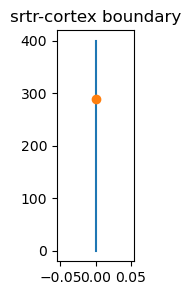

In [132]:
# define paths:

## old data 
data_path = r'Z:\projects\sequence_squad\organised_data\animals\\'
animals  = ['136_1_3', '136_1_4', '149_1_1', '149_1_2', '149_1_3','162_1_3', '178_1_4', '178_1_5', '178_1_6', '178_1_7', '178_1_8','178_1_9', '178_2_1', '178_2_2', '178_2_4', '268_1_10','269_1_4', '269_1_7', '270_1_5', '270_1_6','270_1_7']

## something wrong with '148_2_2',

## new data 
# data_path = r'Z:\projects\sequence_squad\revision_data\organised_data\animals\\'
# animals = ['ap5R_1_1','ap5R_1_2','ap5R_1_3','seq006_1_1','seq006_1_2','seq006_1_3','seq006_1_4','seq006_1_5','seq006_1_6','seq006_1_7','seq006_1_8','seq006_1_9','seq006_1_10','seq006_1_11','seq008_1_3']
# shanks = [1,1,1,3,3,3,3,3,3,3,3,2,1,4,3]


output_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\\"


# loop through all the animals
for overall_run_index, animal in enumerate(animals):

    # list out all possible datapaths
    data_paths = list_all_datapaths(data_path) 

    for path in data_paths:
        if 'EJT' in path:
            a = path.split('\\')[-2].split('_')[0][3::]
        else:
            a = path.split('\\')[-2].split('_')[0]
        b = path.split('\\')[-2][-1]
        c = path.split('\\')[-1].split('_')[0][-1]
        current_mouse = '_'.join([a,b,c])
        if current_mouse != animal:
            continue
        print('-------------------------------------')
        print()
        print(path)
        organised_ephys_path = os.path.join(path, r'ephys\\')
        
        # get the recording folder
        mouse_folder = None
        if 'EJT' in path:
            OE_raw_path,processor_path = gather_paths_for_old_data(current_mouse,path)
        else:
            OE_raw_path, processor_path = gather_paths_for_new_data(current_mouse)
            
        # find processor tuples
        main_processor_tuple,aux_processor_tuples = find_processor_tuples(processor_path)
        
        #!## LOAD in ephys data: WARNING V SLOW - this could take a few minutes ############!#
        
        recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,OE_raw_path)
        recording.compute_global_timestamps()
        
        #!##################################################################################!#
        
        ## Save this out:
        print('saving...')
        if not os.path.isdir(organised_ephys_path):
            os.makedirs(organised_ephys_path)
            
        # check to see if global object alreayd exists and if it does no need to save
        if process_probe_data_bool(organised_ephys_path,aux_processor_tuples) == False:
            save_path = organised_ephys_path + f"global-timstamps_event-df.pkl"
            recording.events.to_pickle(save_path)
        
        ## Extract timestamp data:
        events_df= recording.events

        ## extract the main npx continuous data:
        # work out the data ind
        probeA_data_index = None
        probeA_data_index = None
        ProbeB = False
        if 'EJT' in path:
            for index, item in enumerate(os.listdir(processor_path)):
                meta_data = recording.continuous[i].metadata
                if 'AP' in meta_data['channel_names'][0]:
                    probeA_data_index = index
        else:
            for index, item in enumerate(os.listdir(processor_path)):   
                meta_data = recording.continuous[i].metadata
                if 'ProbeA' in meta_data['stream_name'][i]:
                    probeA_data_index = index
                    
            #extract probe A
            if 'ProbeB' in ''.join(os.listdir(processor_path)[0::]):
                ProbeB = True
                for index, item in enumerate(os.listdir(processor_path)):   
                    meta_data = recording.continuous[i].metadata
                    if 'ProbeB' in meta_data['stream_name'][i]:
                        probeA_data_index = index
                        
        ProbeA_data = recording.continuous[probeA_data_index].samples
        if ProbeB:
            ProbeB_data = recording.continuous[probeB_data_index].samples
            
        #choose 8 channels 
        channels = [50,90,130,170,210,250,290,340]
        
        # import the histology data
        if 'EJT' in path:
            brainreg_base_path = r"Z:\projects\sequence_squad\data\histology\Neuropixel_tracks\\"
            for mouse_name in os.listdir(brainreg_base_path):
                if current_mouse.split('_')[0] in mouse_name:
                    hist_path_base = os.path.join(brainreg_base_path,mouse_name)
                    hist_path = os.path.join((hist_path_base),"brainreg\\")
                    hist_path = glob.glob(os.path.join(hist_path, '**','tracks'),recursive = True)[0]
                    # load the data
                    implant_files = []
                    for item in os.listdir(hist_path):
                        if 'csv' in item:
                            implant_files+=[item]

                    if len(implant_files) > 1:
                        for file in implant_files:
                            if current_mouse.split('_')[-2] in file:
                                implant_file = file
                    else:
                        implant_file = implant_files[0]

                    probe_track_file = os.path.join(hist_path,implant_file) 
                    print(probe_track_file)
                    implant_df = pd.read_csv(probe_track_file)
                    
                    # this is only needed for probe A:
                    striatum_proportion = find_propotion_in_striatum(implant_df)
                    # there should be 400 channels per 4000um (what i implanted), tot_channels = 384, bank_spacing = 20 # 20um, channels_per_bank = 2
                    first_cortex_channel = int(striatum_proportion * 400)
                    total_chans = 400
                    plot_boundary(first_cortex_channel,total_chans)
                                        
        else:
            if ProbeB:
                implant_dfs_A,implant_dfs_B = find_histology_paths(current_mouse,ProbeB)
            else:
                implant_df_A = find_histology_paths(current_mouse,ProbeB)
            first_cortex_channel,total_chans = find_propotion_new_data(implant_dfs_A[0])
            plot_boundary(first_cortex_channel,total_chans)
        
        #label the channels   
        channel_regions = []
        for channel in channels:
            if channel >= first_cortex_channel:
                channel_regions.append('m_crtex')
            elif channel < first_cortex_channel:
                channel_regions.append('striatum')
                
        # process the data for probe A
        process_probe_channels(ProbeA_data,channels,channel_regions,current_mouse,output_path,'striatum_lfp\\')
        
        # same for probe B
        if ProbeB:
            #label the channels for probe B  
            probeB_channel_regions = ['hippocampus'] * len(channels)
            process_probe_channels(ProbeB_data,channels,probeB_channel_regions,current_mouse,output_path,'hippocampus_lfp\\')
            
        # save out the timestamp data

        Fs = 30000
        samples = len(ProbeA_data)
        timestamps_index = np.linspace(0,samples,samples+1).astype(int)
        timestamps_index_downsampled = timestamps_index[::12]
        timestamps_downsampled = timestamps_index_downsampled/Fs
        downsampled_timstamp_df = pd.DataFrame({'sample_number':timestamps_index_downsampled,'ephys_timestamp':timestamps_downsampled})
        mouse_out_path = os.path.join(output_path, 'striatum_lfp\\') + current_mouse + '\\'
        downsampled_timstamp_df.tocsv(mouse_out_path + 'probeA_timestamps.csv')
        
        if ProbeB:
            samples = len(ProbeB_data)
            timestamps_index = np.linspace(0,samples,samples+1).astype(int)
            timestamps_index_downsampled = timestamps_index[::12]
            timestamps_downsampled = timestamps_index_downsampled/Fs
            downsampled_timstamp_df = pd.DataFrame({'sample_number':timestamps_index_downsampled,'ephys_timestamp':timestamps_downsampled})
            mouse_out_path = os.path.join(output_path, 'striatum_lfp\\') + current_mouse + '\\'
            downsampled_timstamp_df.tocsv(mouse_out_path + 'probeB_timestamps.csv')

            

    
    
    


In [147]:
len()

33218777